# Clasificacion de Sentimientos utilizando embeddings sobre dataset financiero

En esta notebook utilizaremos los embeddings entrenados en la notebook anterior, con el dataset financial_news (que posee mas de 200 mil noticias financieras), para predecir los sentimientos de noticias en el dataset con noticias etiquetadas, el cual cuenta con aproximadamente 2000 noticias etiquetadas con sentimientos positivos y negativos.

In [1]:
import pandas as pd
import numpy as np
import gensim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargamos los embeddings entrenados en la notebook anterior 5_1_1.

In [8]:
#load model
import os
filename='/content/drive/MyDrive/Mentoria/Embedding_FinancialNews_word2vec.txt'

embeddings_index={}
f=open(os.path.join('',filename), encoding="utf-8")
for line in f:
  values=line.split()
  word=values[0]
  coefs=np.asarray(values[1:])
  embeddings_index[word]=coefs
f.close()

In [9]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=False)

In [10]:
print("Cantidad de palabras: ", embeddings.vectors.shape[0])
print("Tamaño del vector para cada palabra: ", embeddings.vector_size)

Cantidad de palabras:  94966
Tamaño del vector para cada palabra:  100


## Noticias Financieras etiquetadas con sentimiento

Cargamos el dataset de noticias financieras etiquetadas con sentimientos positivos, neutrales y negativos.


In [11]:
df_sent = pd.read_csv("https://raw.githubusercontent.com/Mentoria-Financiera-DiploDatos/Entrega3/master/sentimientos/data/feeling_procesado.csv")
print(df_sent.news.size)
df_sent.head(3)

4838


,Unnamed: 0,feeling,news,news_tokens,news_tokens_tagged
0,0,neutral,"According to Gran , the company has no plans t...","['accord', 'gran', 'company', 'plan', 'move', ...","[('accord', 'NN'), ('gran', 'VBD'), ('company'..."
1,1,neutral,Technopolis plans to develop in stages an area...,"['technopolis', 'plan', 'develop', 'stage', 'a...","[('technopolis', 'NN'), ('plan', 'NN'), ('deve..."
2,2,negative,The international electronic industry company ...,"['international', 'electronic', 'industry', 'c...","[('international', 'JJ'), ('electronic', 'JJ')..."


In [13]:
# No tenemos en cuenta las noticias etiquetadas como neutrales
df_sent = df_sent[df_sent['feeling'] != 'neutral'].reset_index(drop=True)

df_sent = df_sent.reset_index(drop=True)
print(df_sent.feeling.size)
df_sent.head(3)

1966


,Unnamed: 0,feeling,news,news_tokens,news_tokens_tagged,news_tokens_str
0,2,negative,The international electronic industry company ...,"['international', 'electronic', 'industry', 'c...","[('international', 'JJ'), ('electronic', 'JJ')...",international electronic industry company elco...
1,3,positive,With the new production plant the company woul...,"['new', 'production', 'plant', 'company', 'wou...","[('new', 'JJ'), ('production', 'NN'), ('plant'...",new production plant company would increase ca...
2,4,positive,According to the company 's updated strategy f...,"['accord', 'company', 'update', 'strategy', 'y...","[('accord', 'NN'), ('company', 'NN'), ('update...",accord company update strategy year basware ta...


In [14]:
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          1966 non-null   int64 
 1   feeling             1966 non-null   object
 2   news                1966 non-null   object
 3   news_tokens         1966 non-null   object
 4   news_tokens_tagged  1966 non-null   object
 5   news_tokens_str     1966 non-null   object
dtypes: int64(1), object(5)
memory usage: 92.3+ KB


In [18]:
# Definimos X
X=df_sent['news'].copy()

In [16]:
# Asignamos un 0 a las noticias negativas y 1 a las noticias positivas
df_sent['feeling_bin']= np.where(df_sent['feeling']=='negative',0, 1)

In [14]:
df_sent.head(3)

,Unnamed: 0,feeling,news,news_tokens,news_tokens_tagged,news_tokens_str,feeling_bin
0,2,negative,The international electronic industry company ...,"['international', 'electronic', 'industry', 'c...","[('international', 'JJ'), ('electronic', 'JJ')...",international electronic industry company elco...,0
1,3,positive,With the new production plant the company woul...,"['new', 'production', 'plant', 'company', 'wou...","[('new', 'JJ'), ('production', 'NN'), ('plant'...",new production plant company would increase ca...,1
2,4,positive,According to the company 's updated strategy f...,"['accord', 'company', 'update', 'strategy', 'y...","[('accord', 'NN'), ('company', 'NN'), ('update...",accord company update strategy year basware ta...,1


In [19]:
# Almacenamos etiquetas en y
y=df_sent['feeling_bin'].values

Realizamos un preprocesado eliminando signos de puntuacion, simbolos no alfabeticos y llevando todo a minusculas. Conservamos stopwords ya que en un trabajo anterior obteniamos mejores resultados de esta forma.

In [32]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
import string
from nltk.tokenize import word_tokenize

news_lines= list()
lines=X.tolist()

for line in lines:
  tokens= word_tokenize(line)
  #to lower case
  tokens=[w.lower() for w in tokens]
  # remove puntuaction from each word
  table=str.maketrans('','',string.punctuation)
  stripped= [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words=[word for word in stripped if word.isalpha()]
  news_lines.append(words)

In [36]:
len(news_lines)

1966

In [23]:
X.shape , news_lines.shape

((1966,), (1966,))

In [41]:
max([len(s) for s in news_lines])

49

## Tokenizado y creacion de matriz de embeddings

Tokenizamos las noticias y realizamos un padding

In [42]:
# vectorize the text sample into a 2D integer tensor

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj= Tokenizer()
tokenizer_obj.fit_on_texts(news_lines)
sequences=tokenizer_obj.texts_to_sequences(news_lines)

max_length=max([len(s) for s in news_lines])

#pad sequences
word_index=tokenizer_obj.word_index
print('Found %s unique tokens.' %len(word_index))

news_pad=pad_sequences(sequences,maxlen=max_length)
sentiment=y
print('Shape of reviews tensor',news_pad.shape)
print('Shape of sentiment tensor:',sentiment.shape)

Found 4975 unique tokens.
Shape of reviews tensor (1966, 49)
Shape of sentiment tensor: (1966,)


In [43]:
news_pad.shape

(1966, 49)

Creamos la matriz de embeddings para la capa de Embeddings, cada fila de esta matriz contiene el vector de embedding de cada uno de los tokens encontrados en el dataset de noticias.

In [44]:
EMBEDDING_DIM=100

In [45]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))

for word,i in word_index.items():
  if i> num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros
    embedding_matrix[i]=embedding_vector

In [46]:
embedding_matrix.shape

(4976, 100)

## Modelos


Separamos el dataset de noticias en conjuntos de entrenamiento y test

In [51]:
# split data into a training set and a validation set
VALIDATION_SPLIT=0.2

indices=np.arange(news_pad.shape[0])
np.random.shuffle(indices)
news_pad=news_pad[indices]
sentiment=y[indices]
num_validation_samples=int(VALIDATION_SPLIT*news_pad.shape[0])

X_train_pad=news_pad[:-num_validation_samples]
y_train=sentiment[:-num_validation_samples]
X_test_pad=news_pad[-num_validation_samples:]
y_test=sentiment[-num_validation_samples:]

print('Shape of X_train_pad tensor: ', X_train_pad.shape)
print('Shape of y_train tensor: ', y_train.shape)
print('Shape of X_test_pad tensor: ', X_test_pad.shape)
print('Shape of y_test tensor: ', y_test.shape)

Shape of X_train_pad tensor:  (1573, 49)
Shape of y_train tensor:  (1573,)
Shape of X_test_pad tensor:  (393, 49)
Shape of y_test tensor:  (393,)


Agregamos las metricas recall, precision, f1 para el entrenamiento y evaluacion de los modelos con keras.

In [55]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Modelo 1 : GRU

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

#define model
model=Sequential()
embedding_layer=Embedding(num_words,
                          EMBEDDING_DIM,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=max_length,
                          trainable=False)

model.add(embedding_layer) # ver
model.add(GRU(units=24,dropout=0.2,recurrent_dropout=0.2)) #ver
model.add(Dense(1,activation='sigmoid'))  # ver 

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc',f1_m,precision_m, recall_m])

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 49, 100)           497600    
_________________________________________________________________
gru_2 (GRU)                  (None, 24)                9072      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 506,697
Trainable params: 9,097
Non-trainable params: 497,600
_________________________________________________________________


In [77]:
print('train....')

history_1 = model.fit(X_train_pad,y_train,batch_size=32,epochs=20,validation_data=(X_test_pad,y_test),verbose=2)

train....
Epoch 1/20
50/50 - 2s - loss: 0.1883 - acc: 0.9199 - f1_m: 0.9421 - precision_m: 0.9376 - recall_m: 0.9490 - val_loss: 0.3487 - val_acc: 0.8906 - val_f1_m: 0.9286 - val_precision_m: 0.9130 - val_recall_m: 0.9466
Epoch 2/20
50/50 - 2s - loss: 0.2067 - acc: 0.9142 - f1_m: 0.9366 - precision_m: 0.9366 - recall_m: 0.9399 - val_loss: 0.3377 - val_acc: 0.8830 - val_f1_m: 0.9237 - val_precision_m: 0.9125 - val_recall_m: 0.9368
Epoch 3/20
50/50 - 2s - loss: 0.1928 - acc: 0.9199 - f1_m: 0.9398 - precision_m: 0.9339 - recall_m: 0.9490 - val_loss: 0.3464 - val_acc: 0.8830 - val_f1_m: 0.9243 - val_precision_m: 0.9078 - val_recall_m: 0.9436
Epoch 4/20
50/50 - 2s - loss: 0.1777 - acc: 0.9352 - f1_m: 0.9528 - precision_m: 0.9523 - recall_m: 0.9556 - val_loss: 0.3450 - val_acc: 0.8855 - val_f1_m: 0.9258 - val_precision_m: 0.9067 - val_recall_m: 0.9472
Epoch 5/20
50/50 - 2s - loss: 0.1813 - acc: 0.9237 - f1_m: 0.9419 - precision_m: 0.9432 - recall_m: 0.9443 - val_loss: 0.3562 - val_acc: 0.890

In [81]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test_pad, y_test, batch_size=128)


Evaluate on test data
4/4 [==============================] - 0s 13ms/step - loss: 0.3885 - acc: 0.8702 - f1_m: 0.9309 - precision_m: 0.9226 - recall_m: 0.9404


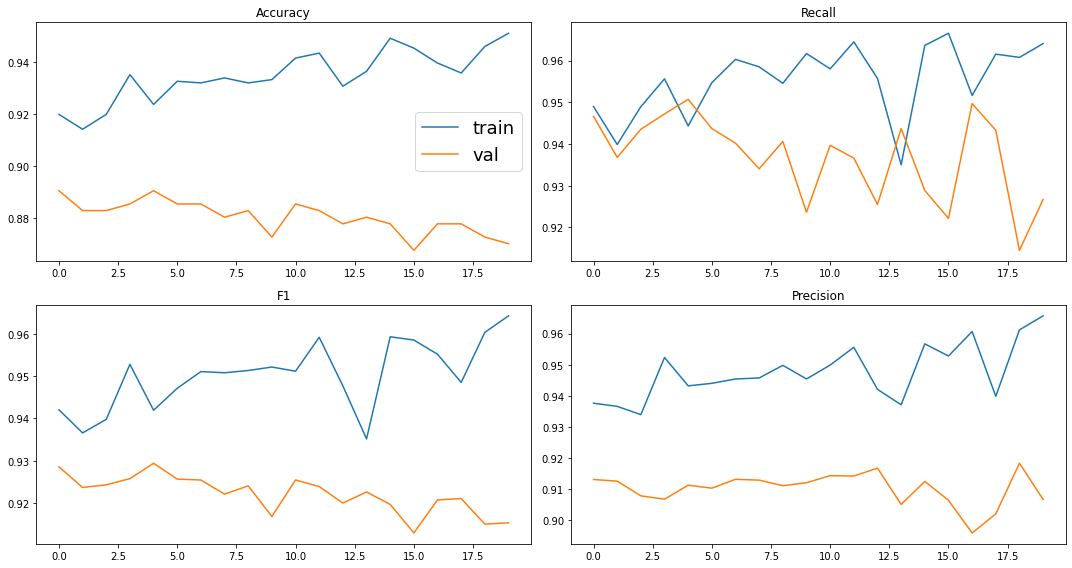

In [82]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs[0, 0].plot(history_1.history['acc'], label='train')
axs[0, 0].plot(history_1.history['val_acc'], label='val')
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend(prop={'size': 18})
axs[1, 0].plot(history_1.history['f1_m'])
axs[1, 0].plot(history_1.history['val_f1_m'])
axs[1, 0].set_title("F1")

axs[0, 1].plot(history_1.history['recall_m'])
axs[0, 1].plot(history_1.history['val_recall_m'])
axs[0, 1].set_title("Recall")

axs[1, 1].plot(history_1.history['precision_m'])
axs[1, 1].plot(history_1.history['val_precision_m'])
axs[1, 1].set_title("Precision")

fig.tight_layout()

### Modelo 2: LSTM

In [83]:
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D

model_2=Sequential()
embedding_layer=Embedding(num_words,
                          EMBEDDING_DIM,
                          embeddings_initializer=Constant(embedding_matrix),
                          input_length=max_length,
                          trainable=False)

model_2.add(embedding_layer) # ver

model_2.add(SpatialDropout1D(0.25))
model_2.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model_2.add(Dropout(0.5))
model_2.add(Dense(1, activation='sigmoid')) 
model_2.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])  

In [84]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 49, 100)           497600    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 49, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 527,851
Trainable params: 30,251
Non-trainable params: 497,600
_________________________________________________________________


In [85]:
X_train_pad.shape

(1573, 49)

In [86]:
history_2 = model_2.fit(X_train_pad,y_train,batch_size=32,epochs=30,validation_split=0.2,verbose=2)

Epoch 1/30
40/40 - 6s - loss: 0.6844 - acc: 0.5612 - f1_m: 0.6721 - precision_m: 0.6943 - recall_m: 0.6632 - val_loss: 0.6314 - val_acc: 0.6540 - val_f1_m: 0.7845 - val_precision_m: 0.6636 - val_recall_m: 0.9623
Epoch 2/30
40/40 - 3s - loss: 0.6523 - acc: 0.6312 - f1_m: 0.7494 - precision_m: 0.7037 - recall_m: 0.8142 - val_loss: 0.6189 - val_acc: 0.6635 - val_f1_m: 0.7937 - val_precision_m: 0.6630 - val_recall_m: 0.9905
Epoch 3/30
40/40 - 3s - loss: 0.6081 - acc: 0.6892 - f1_m: 0.8004 - precision_m: 0.7198 - recall_m: 0.9108 - val_loss: 0.6132 - val_acc: 0.6603 - val_f1_m: 0.7910 - val_precision_m: 0.6618 - val_recall_m: 0.9850
Epoch 4/30
40/40 - 3s - loss: 0.6077 - acc: 0.6749 - f1_m: 0.7899 - precision_m: 0.7094 - recall_m: 0.8988 - val_loss: 0.5997 - val_acc: 0.6603 - val_f1_m: 0.7910 - val_precision_m: 0.6618 - val_recall_m: 0.9850
Epoch 5/30
40/40 - 3s - loss: 0.5977 - acc: 0.6741 - f1_m: 0.7884 - precision_m: 0.7158 - recall_m: 0.8845 - val_loss: 0.6081 - val_acc: 0.6698 - val_f1

In [87]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_2.evaluate(X_test_pad, y_test, batch_size=128)
#print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 0s 24ms/step - loss: 0.3130 - acc: 0.8804 - f1_m: 0.8898 - precision_m: 0.8761 - recall_m: 0.9045


In [88]:
history_2

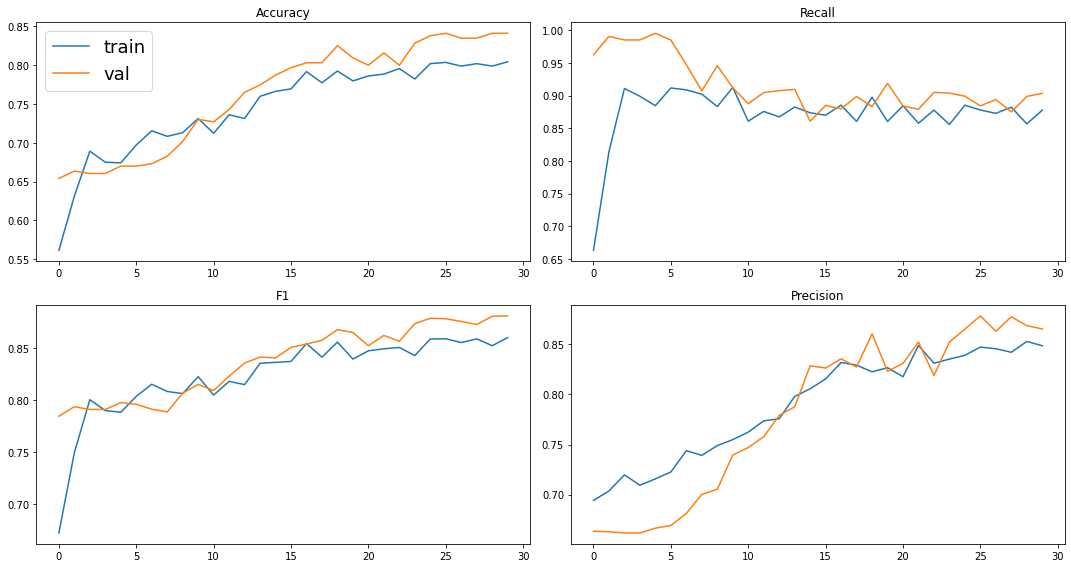

In [89]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs[0, 0].plot(history_2.history['acc'], label='train')
axs[0, 0].plot(history_2.history['val_acc'], label='val')
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend(prop={'size': 18})
axs[1, 0].plot(history_2.history['f1_m'])
axs[1, 0].plot(history_2.history['val_f1_m'])
axs[1, 0].set_title("F1")

axs[0, 1].plot(history_2.history['recall_m'])
axs[0, 1].plot(history_2.history['val_recall_m'])
axs[0, 1].set_title("Recall")

axs[1, 1].plot(history_2.history['precision_m'])
axs[1, 1].plot(history_2.history['val_precision_m'])
axs[1, 1].set_title("Precision")

fig.tight_layout()